In [35]:
import pandas as pd
import hashlib
import pandahouse
import seaborn as sns
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot
sns.set(rc = {'figure.figsize' : (12,6)})

In [10]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240120'
}

# Задание №2
Эксперимент проходил с 2023-12-29 по 2024-01-04 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).

Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 

Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.

Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

### Подсоединимся к Clickhouse  и соберем датасет в который положим посчитанные по пользователям лайки, просмотры и CTR для экспериментальных групп 1 и 2

In [11]:
q = """
select exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
from {db}.feed_actions
where toDate(time) between '2023-12-29' and '2024-01-04'
    and exp_group in (1,2)
    group by exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection = connection)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19897 entries, 0 to 19896
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  19897 non-null  int8   
 1   user_id    19897 non-null  uint32 
 2   likes      19897 non-null  uint64 
 3   views      19897 non-null  uint64 
 4   ctr        19897 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 563.6 KB


In [97]:
print(f'{df[df.exp_group == 1].user_id.count()} пользователей в группе № 1')
print(f'{df[df.exp_group == 2].user_id.count()} пользователей в группе № 2')

print(f'{df[df.exp_group == 1].ctr.mean()} - средний CTR пользователей в группе № 1')
print(f'{df[df.exp_group == 2].ctr.mean()} - средний CTR пользователей в группе № 2')

10020 пользователей в группе № 1
9877 пользователей в группе № 2
0.216773994120072 - средний CTR пользователей в группе № 1
0.2161016893237817 - средний CTR пользователей в группе № 2


<Axes: xlabel='ctr', ylabel='Count'>

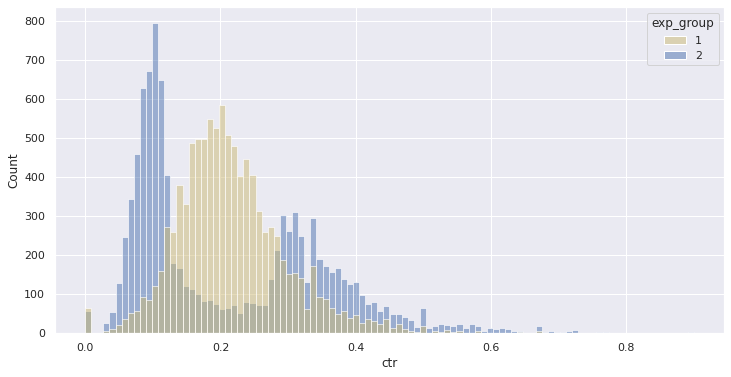

In [98]:
sns.histplot(data = df, x = 'ctr',hue = 'exp_group', bins = 100, palette = ['y','b'])



### Всего у нас 16787 пользователей. Распределены они примерно равномерно. Средний CTR в первой группе (контроль) выше чем во второй (тест)
### Мы видим, что распределение в группе №2 двумодальное. То есть его нельзя считать нормальным. 
### Проведем тесты для сравнения CTR в группах

## T-Test

In [15]:
ss.ttest_ind(df[df.exp_group == 1].ctr,df[df.exp_group == 2].ctr,equal_var = False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

### Т-тест не показал различий в средних значениях CTR между группами. Однако, поскольку т-тест чувствителен к отклонениям от нормальности эти результаты можно посавить под сомнение.
## Тест Манна-Уитни

In [16]:
ss.mannwhitneyu(df[df.exp_group == 1].ctr,df[df.exp_group == 2].ctr)

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [24]:
%%time
A_gt_B = 0
for _ in range(10000):
    A_gt_B += df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
print('B', A_gt_B/100, '% случаев значение CTR в первой группе больше чем во второй')

B 55.73  случаев значение CTR в первой группе больше чем во второй
CPU times: user 22.1 s, sys: 5.62 ms, total: 22.1 s
Wall time: 22.3 s


### Мы зафиксировали значение P-value в тесте намного меньше чем порог значимости, а значит тест зафиксировал статистически значимые различия в наших группах.С большой долей вероятности мы можем утверждать, что CTR в первой группе выше чем во второй и это не случайно
## Сглаженный CTR (Smooth CTR)
### Напишем функцию сглаживания CTR


In [37]:
def get_smoothed_ctr(likes,views,global_ctr,alpha):
    smoothed_ctr = (likes + global_ctr*alpha) / (views +alpha)
    return smoothed_ctr

### определим общегрупповой CTR для групп 1 и 2

In [42]:
global_ctr1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
global_ctr2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

### Рассчитаем поюзерно сглаженный CTR. При этом гиперпараметр альфа = 5

In [56]:
group1 = df[df.exp_group == 1].copy()
group1['smoothed_ctr'] = group1.apply(lambda x : get_smoothed_ctr(x['likes'],x['views'],global_ctr1,5),axis = 1)
                                                                    
group2 = df[df.exp_group == 2].copy()
group2['smoothed_ctr'] = group2.apply(lambda x : get_smoothed_ctr(x['likes'],x['views'],global_ctr1,5),axis = 1)                                                                    

<Axes: xlabel='ctr', ylabel='Count'>

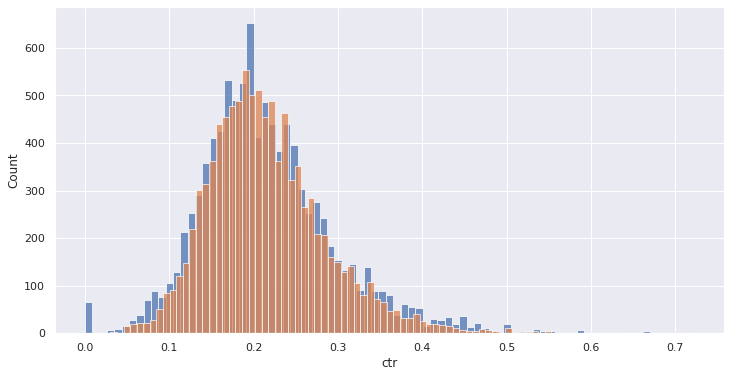

In [57]:

sns.histplot(data = group1,x = 'ctr')
sns.histplot(data = group1,x = 'smoothed_ctr')

In [58]:
ss.ttest_ind(group1.smoothed_ctr,group2.smoothed_ctr,equal_var = False)

Ttest_indResult(statistic=1.2447034376197381, pvalue=0.2132595139150962)

### Проверим тест на разных значениях гиперпарамета альфа

<Axes: >

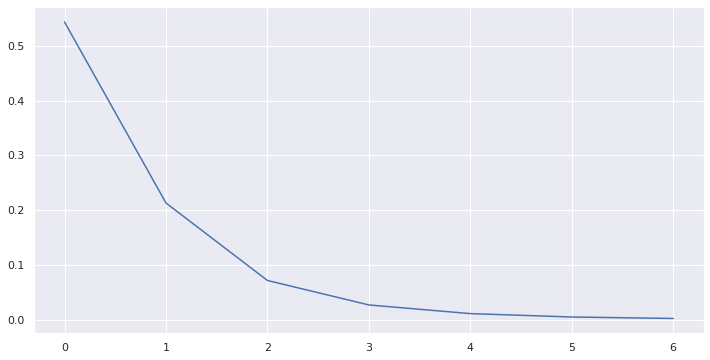

In [64]:
pvalues = []
for alpha in (1,5,10,15,20,25,30):
    group1 = df[df.exp_group == 1].copy()
    group1['smoothed_ctr'] = group1.apply(lambda x : get_smoothed_ctr(x['likes'],x['views'],global_ctr1,alpha),axis = 1)
                                                                    
    group2 = df[df.exp_group == 2].copy()
    group2['smoothed_ctr'] = group2.apply(lambda x : get_smoothed_ctr(x['likes'],x['views'],global_ctr1,alpha),axis = 1) 

    test = ss.ttest_ind(group1.smoothed_ctr,group2.smoothed_ctr,equal_var = False)
    pvalues.append( test.pvalue)
sns.lineplot(pvalues)

In [61]:
pvalues

[0.2132595139150962,
 0.0720196054667731,
 0.027378761451629263,
 0.011600247193359671,
 0.005394111920378082,
 0.0027141567601868715]

### тест не выявил статистически значимых различий в CTR между группами. Однако изменяя гиперпараметр альфа можно добиться иных результатов. В связи с чем я не считаю этот тест достаточно надежным, чтобы быть уверенным в его результатах

## Bootstrap
### Напишем функцию пуассоновского бутстрепа

In [69]:
def bootstrap(likes1,views1,likes2,views2,n_bootstrap = 5000):
    weight_1  = ss.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    weight_2  = ss.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    global_CTR1 = (weight_1*likes1).sum(axis = 1)/(weight_1*views1).sum(axis = 1)
    global_CTR2 = (weight_2*likes2).sum(axis = 1)/(weight_2*views2).sum(axis = 1)
    
    return global_CTR1,global_CTR2


### Применим ее к нашим группам 

In [70]:
%%time
likes1 = df[df.exp_group == 1].likes.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1,ctr2 = bootstrap(likes1,views1,likes2,views2)

CPU times: user 6.17 s, sys: 3.17 s, total: 9.33 s
Wall time: 9.48 s


In [86]:
d = {'ctr1':ctr1,'ctr2':ctr2}
bootstrep = pd.DataFrame(data = d)

<Axes: ylabel='Count'>

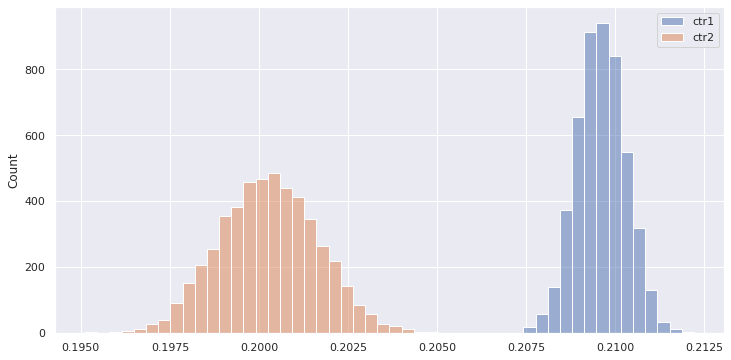

In [91]:

sns.histplot(data = bootstrep, bins = 50)


In [74]:
ss.ttest_ind(ctr1,ctr2,equal_var = False)

Ttest_indResult(statistic=423.4466068192122, pvalue=0.0)

### Бутстреп однозначно показывает наличие статистически значимых различий между выборками. При этом общегрупповой CTR в группе 1 выше чем в группе 2

## Bucket distribution
### Сделаем запрос к базе данных для получения распределения наших пользователей по корзинам с подсчетом внутригруппового CTR внутри каждой корзины

In [93]:
q2 = """
select
    exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr
from (
    select
        exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
    from {db}.feed_actions
    where toDate(time) between '2023-12-29' and '2024-01-04'
        and exp_group in (1,2)
        group by exp_group, user_id)
group by exp_group,bucket
"""
df2 = pandahouse.read_clickhouse(q2, connection = connection)

In [94]:
df2

,exp_group,bucket,bucket_ctr
0,1,0,0.200592
1,2,0,0.196510
2,1,1,0.208799
3,2,1,0.210375
4,1,2,0.204632
...,...,...,...
95,2,47,0.196808
96,1,48,0.216369
97,2,48,0.194780
98,1,49,0.206288


### проведем т-тест для CTR поверх бакетного преобразования

In [95]:
ss.ttest_ind(df2[df2.exp_group == 1].bucket_ctr,df2[df2.exp_group == 2].bucket_ctr,equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

### проведем тест Манна-Уитни для CTR поверх бакетного преобразования

In [96]:
ss.mannwhitneyu(df2[df2.exp_group == 1].bucket_ctr,df2[df2.exp_group == 2].bucket_ctr)

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

### Как т-тест, так и тест Манна-Уитни показали статистически значимые различия в CTR между группами пользователей 

# Ответы:
### 1. Мы провели ряд тестов для определения наличия изменений вызванных нашими преобразованиями. Результаты описаны выше
### 2. Учитывая, что распределение пользователей в группе 2 очевидно имеет отклонения от нормальности мы можем усомниться в результатах т-теста Стъюдента. Также сомнения вызывают результаты т-теста на сглаженном CTR, поскольку, в зависимости от гиперпараметра альфа мы получаем разные результаты теста. Остальные тесты менее чувствительны к нормальности распределения и показывают наличие статистически значимых различий между группами. При этом CTR в тестовой группе ниже чем в контрольной.
### 3. Глядя на гистограмму распределения CTR пользователей в тестовой группе мы видим, что для на графике есть две моды. Предположительно наши изменения вызвали противоположные реакции у пользователей: одна часть одобрительно отнеслась к ним и стала больше лайкать, другая же наоборот, стала лайкать меньше. В среднем СTR как метрика одобрения пользователей уменьшился.
### 4. Проведенные тесты показали, что либо различий нет, либо CTR уменьшился, а значит раскатывать алгоритм на всех пользователей не имеет смысла
